In [1]:
import pandas as pd
import numpy as np
from sklearn.mixture import GaussianMixture
from statistics import NormalDist
from genetic_algorithm import GeneticAlgorithm as GA

In [2]:
data = pd.read_pickle("MVIX.pkl")
print(data)
data.reset_index(drop=True, inplace = True)
data = np.log(data).diff()[1:].to_numpy()

         Adj Close
1990-01  25.360001
1990-02  21.990000
1990-03  19.730000
1990-04  19.520000
1990-05  17.370001
...            ...
2019-08  18.980000
2019-09  16.240000
2019-10  13.220000
2019-11  12.620000
2019-12  13.780000

[360 rows x 1 columns]


In [3]:
print(min(data))
print(max(data))

[-0.4859671]
[0.85258795]


In [4]:
from sklearn.mixture import GaussianMixture
gm = GaussianMixture(n_components=3, random_state=0).fit(data)
weights = gm.weights_
mean = gm.means_
sigma = np.sqrt(gm.covariances_)
weight = gm.weights_

In [5]:
sigma = sigma.reshape(3, 1)

In [6]:
M = 48
N = data.shape[0]
k = 3
hist = np.histogram(data, bins = M)
phat = hist[0]/N
boundaries = hist[1]
print(phat.shape, boundaries.shape)

(48,) (49,)


In [7]:
def objective(theta, lbda):
    s = 0
    for j in range(M):
        up = 0
        for i in range(k):
            Mu, Sigma, Pi = theta[i]
            dist = NormalDist(mu = Mu, sigma = Sigma)
            up += Pi * (dist.cdf(boundaries[j+1]) - dist.cdf(boundaries[j]))
        if (phat[j] > 0.0 and up > 0.0):
            s += phat[j] * np.log(up/phat[j])
    first = -2 * N * s
    second = lbda * abs(np.sum(theta[:,2]) - 1)
   #print (np.sum(theta[:,2]))
    return first + second

def lagrange(params):
    theta = np.zeros((k,3))
    lmbda = params[-1]
    for i in range(k):
        theta[i][0] = params[3*i]
        theta[i][1] = params[3*i+1]
        theta[i][2] = params[3*i+2]
    res = objective(theta, lmbda)
    return res

In [8]:
varBound = []
muBound = [-1.0, 1.0]
sigmaBound = [1e-5, 2.0]
if k != 1:
    piBound = [1e-4,0.99]
else:
    piBound = [1, 1]
lmbdaBound = [1e4,1e5]
for i in range(k):
    varBound.append(muBound)
    varBound.append(sigmaBound)
    varBound.append(piBound)
varBound.append(lmbdaBound)
varBound = np.array(varBound)
pd.DataFrame(varBound)

,0,1
0,-1.00000,1.00
1,0.00001,2.00
2,0.00010,0.99
3,-1.00000,1.00
4,0.00001,2.00
5,0.00010,0.99
6,-1.00000,1.00
7,0.00001,2.00
8,0.00010,0.99
9,10000.00000,100000.00


 The best solution found:                                                                           
 [-1.41024103e-01  1.20899179e-01  2.74480121e-01  2.79466232e-02
  1.31417824e-01  5.41970397e-01  1.47294835e-01  2.30864141e-01
  1.83519720e-01  1.09155480e+04]

 Objective function:
 48.28140042725576


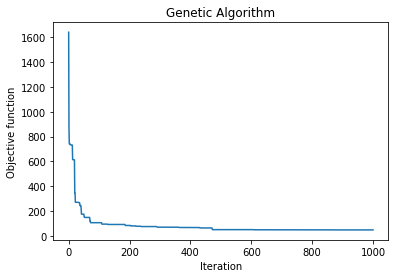

In [9]:
algorithm_param = {'max_num_iteration': 1000,\
                   'population_size':100,\
                   'mutation_probability':0.1,\
                   'elit_ratio': 0.01,\
                   'crossover_probability': 0.5,\
                   'parents_portion': 0.3,\
                   'crossover_type':'uniform',\
                   'max_iteration_without_improv':None}
model = GA(function=lagrange, dimension=3*k+1,\
              variable_type='real',\
              variable_boundaries=varBound,
             algorithm_parameters=algorithm_param)
model.run()

In [10]:
coef = model.best_variable[:-1]
#coef = coef.reshape(4, 3)
#coef = pd.DataFrame(coef)
#coef

In [11]:
theta = coef.reshape(3, 3)
print(theta)

[[-0.1410241   0.12089918  0.27448012]
 [ 0.02794662  0.13141782  0.5419704 ]
 [ 0.14729483  0.23086414  0.18351972]]


In [12]:
weight = weight.reshape(3, 1)

In [13]:
### Question 4
theta = np.hstack((mean, sigma, weight))
print(theta[0])
a, b, c = theta[0]
print(a,b,c)

[-0.14890661  0.12651819  0.35845899]
-0.1489066115970257 0.12651819051227542 0.35845899459006886


In [33]:
theta = np.array([0.0908, 0.213, 0.25,
    0.197, 0.316, 0.029,
    -0.046, 0.142, 0.718])

theta = theta.reshape(3, 3)
theta

array([[ 0.0908,  0.213 ,  0.25  ],
       [ 0.197 ,  0.316 ,  0.029 ],
       [-0.046 ,  0.142 ,  0.718 ]])

In [30]:
best_regime = []
mcp = []
for i in range(data.shape[0]):
    f_j = []
    for j in range(k):
        Mu, Sigma = theta[j, 0], theta[j, 1]
        f_j.append(theta[j, 2] * NormalDist(mu = Mu, sigma = Sigma).pdf(data[i,0]))
        if f_j[-1] >= max(f_j):
            best_regime_i = j
    mcp_i = max(f_j)/sum(f_j)
    best_regime.append(best_regime_i)
    mcp.append(mcp_i)

In [31]:
transition = np.zeros(shape = (3, 3))
row_0_sum = 0
row_1_sum = 0
row_2_sum = 0
for i in range(len(best_regime)-1):
    if best_regime[i] == 0:
        row_0_sum +=1
        if best_regime[i+1] == 0:
            transition[0,0] += 1
        elif best_regime[i+1] == 1:
            transition[0, 1] += 1
        else:
            transition[0, 2] += 1
    elif best_regime[i] == 1:
        row_1_sum +=1
        if best_regime[i+1] == 0:
            transition[1,0] += 1
        elif best_regime[i+1] == 1:
            transition[1, 1] += 1
        else:
            transition[1, 2] += 1
    else:
        row_2_sum += 1
        if best_regime[i+1] == 0:
            transition[2,0] += 1
        elif best_regime[i+1] == 1:
            transition[2, 1] += 1
        else:
            transition[2, 2] += 1
transition[0,:] = transition[0,:]/row_0_sum
transition[1,:] = transition[1,:]/row_1_sum
transition[2,:] = transition[2,:]/row_2_sum



In [32]:
transition

array([[0.20930233, 0.        , 0.79069767],
       [0.        , 0.        , 1.        ],
       [0.10828025, 0.00318471, 0.88853503]])